# Import the libraries

In [1]:
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

# Parameters 

In [2]:
learning_rate=0.01
epochs=20
batch_size=4


# Import the dataset

In [3]:
train_path='training_set/'
test_path='test_set/'

data_transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize([0.0,0.0,0.0],[1.0,1.0,1.0])
])

train_dataset=datasets.ImageFolder(root=train_path,transform=data_transforms)
test_dataset=datasets.ImageFolder(root=test_path,transform=data_transforms)

print(f"Number of training dataset: {len(train_dataset)}")
print(f"Number of testing dataset: {len(test_dataset)}")


Number of training dataset: 8005
Number of testing dataset: 2023


In [4]:
train_dataset.classes[0]

'cats'

In [5]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

print(f"Number of training loader: {len(train_loader)}")
print(f"Number of testing loader: {len(test_loader)}")

Number of training loader: 2002
Number of testing loader: 506


# Show the images

In [6]:
def show_images(dataset):
    plt.figure(figsize=(9,9))
    data_loader=next(iter(train_loader))
    images,labels=data_loader
    
    grid=torchvision.utils.make_grid(images)
    
    grid=grid.numpy()
    grid=np.transpose(grid,(1,2,0))
    
    plt.title([train_dataset.classes[labels[i]] for i in range(batch_size)])
    plt.imshow(grid)

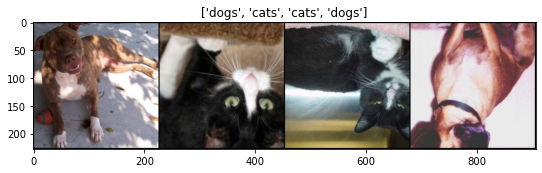

In [7]:
show_images(train_dataset)

# Build Our CNN Model

In [8]:
images,labels=next(iter(train_loader))


print(images.shape)

conv2d=nn.Conv2d(3,8,kernel_size=3)
y=conv2d(images)
print(y.shape)


maxpool=nn.MaxPool2d(kernel_size=2)
y=maxpool(y)
print(y.shape)

conv2d=nn.Conv2d(8,32,kernel_size=5)
y=conv2d(y)
print(y.shape)


maxpool=nn.MaxPool2d(kernel_size=2)
y=maxpool(y)
print(y.shape)

conv2d=nn.Conv2d(32,32,kernel_size=5)
y=conv2d(y)
print(y.shape)


maxpool=nn.MaxPool2d(kernel_size=2)
y=maxpool(y)
print(y.shape)


y=y.view(-1,y.size(1)*y.size(2)*y.size(3))
print(y.shape)

y.flatten().shape


torch.Size([4, 3, 224, 224])
torch.Size([4, 8, 222, 222])
torch.Size([4, 8, 111, 111])
torch.Size([4, 32, 107, 107])
torch.Size([4, 32, 53, 53])
torch.Size([4, 32, 49, 49])
torch.Size([4, 32, 24, 24])
torch.Size([4, 18432])


torch.Size([73728])

In [9]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3)
        self.batch1=nn.BatchNorm2d(8)
        self.conv2=nn.Conv2d(in_channels=8,out_channels=32,kernel_size=5)
        self.batch2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5)
        self.batch3=nn.BatchNorm2d(32)


     
        self.pool=nn.MaxPool2d(kernel_size=(2,2))
        self.dropout=nn.Dropout(p=0.4)
        
        
        self.fc1=nn.Linear(in_features=32*24*24,out_features=250)
        self.fc2=nn.Linear(in_features=250,out_features=200)
        self.fc3=nn.Linear(in_features=200,out_features=1)


        
    def forward(self,x):
    
        x=self.pool(F.relu(self.batch1(self.conv1(x))))
        x=self.pool(F.relu(self.batch2(self.conv2(x))))
        x=self.pool(F.relu(self.batch3(self.conv3(x))))


        
        x=x.view(-1,32*24*24)
        
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))

        x=self.fc3(x)
        
        return x

        
        

In [10]:
model=CNN_Model().to(device)

loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-5)

model

CNN_Model(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=18432, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)

In [14]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [11]:
import time
start=time.time()

test_loss,test_acc=[],[]
train_loss,train_acc=[],[]
output_results=[]


CPU=torch.device('cpu')
CUDA=torch.device('cuda')

model=model.to(CUDA)

for epoch in range(epochs):
    n_correct=0
    batch_iter=0
    batch_loss=0.0
    model.train()
    
    for i,(images,labels) in enumerate(train_loader):
        images=images.to(CUDA)
        labels=labels.to(CUDA)
        
        # Forward pass - prediction
        output=model(images)
        
        #Compute loss value
        loss_val=loss_fn(output,labels.unsqueeze(1).float())
        batch_loss+=loss_val.item()
        
        #Zero gradients
        optimizer.zero_grad()
        
        #Backward loss value
        loss_val.backward()
        
        #Update weights
        optimizer.step()
        
        #Get predicted results
        n_correct+=(torch.where(output>0.5,1,0)==labels.unsqueeze(1)).sum().item()

        
        
        batch_iter+=1
        
    train_loss.append(batch_loss/batch_iter)
    train_acc.append(100*n_correct/len(train_dataset))
    
    #TESTING PHASE
            
    
    with torch.no_grad():
        
        n_correct=0
        batch_iter=0
        batch_loss=0.0
        model.eval()


        for i,(images,labels) in enumerate(test_loader):
            images=images.to(CUDA)
            labels=labels.to(CUDA)

            #Forward pass - prediction
            output=model(images)

            #Compute loss function
            loss_val=loss_fn(output,labels.unsqueeze(1).float())
            batch_loss+=loss_val.item()

            #Get predicted results
            n_correct+=(torch.where(output>0.5,1,0)==labels.unsqueeze(1)).sum().item()


            batch_iter+=1

        test_loss.append(batch_loss/batch_iter)
        test_acc.append(100*n_correct/len(test_dataset))
        output_results.append(output)

        print(f"Epoch[{epoch+1}/{epochs}]  Train Loss:{train_loss[-1]:.3f}  Train Accuracy:{train_acc[-1]:.3f}")
        print(f"Epoch[{epoch+1}/{epochs}]  Test Loss:{test_loss[-1]:.3f}  Test Accuracy:{test_acc[-1]:.3f}")
        print("-----------------------------------------")
        
        
end=time.time()
print(f"Duration: {end-start}")
        
        
        
        

Epoch[1/20]  Train Loss:0.684  Train Accuracy:53.229
Epoch[1/20]  Test Loss:0.668  Test Accuracy:53.139
-----------------------------------------
Epoch[2/20]  Train Loss:0.653  Train Accuracy:58.014
Epoch[2/20]  Test Loss:0.634  Test Accuracy:59.713
-----------------------------------------
Epoch[3/20]  Train Loss:0.629  Train Accuracy:61.537
Epoch[3/20]  Test Loss:0.620  Test Accuracy:59.268
-----------------------------------------
Epoch[4/20]  Train Loss:0.612  Train Accuracy:63.048
Epoch[4/20]  Test Loss:0.594  Test Accuracy:67.375
-----------------------------------------
Epoch[5/20]  Train Loss:0.594  Train Accuracy:65.109
Epoch[5/20]  Test Loss:0.567  Test Accuracy:67.820
-----------------------------------------
Epoch[6/20]  Train Loss:0.577  Train Accuracy:66.471
Epoch[6/20]  Test Loss:0.562  Test Accuracy:68.067
-----------------------------------------
Epoch[7/20]  Train Loss:0.564  Train Accuracy:68.470
Epoch[7/20]  Test Loss:0.545  Test Accuracy:72.368
--------------------

In [19]:
print(f"{n_correct}/{len(test_dataset)} correct results")

1586/2023 correct results


In [30]:
(torch.where(output>0.5,1,0)==labels.unsqueeze(1)).sum().item()

2

In [17]:
output_results[0]

tensor([[-0.1284],
        [-0.5558],
        [-0.6542]], device='cuda:0')

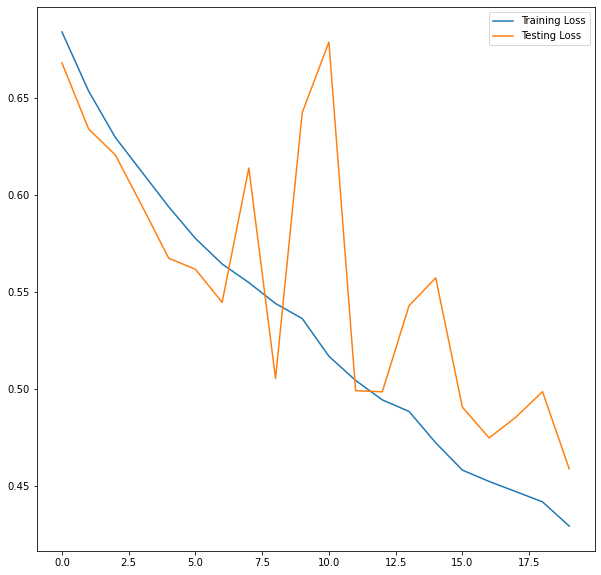

In [12]:
#Plotting the loss
f=plt.figure(figsize=(10,10))
plt.plot(train_loss,label="Training Loss")
plt.plot(test_loss,label="Testing Loss")
plt.legend()
plt.show()

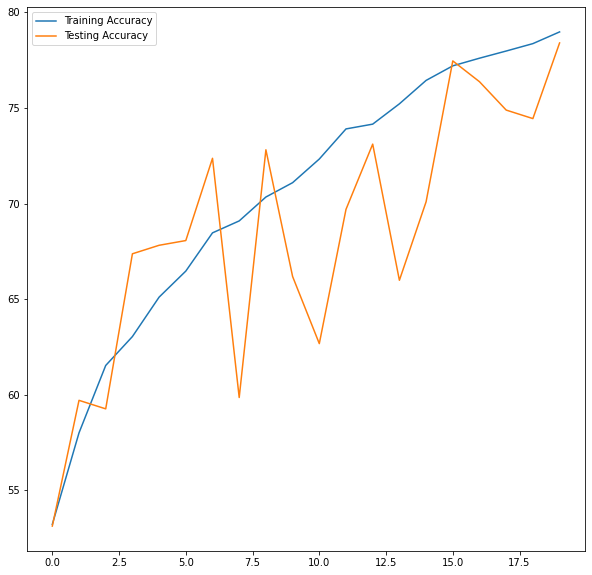

In [13]:
#Plotting the accuracy
f=plt.figure(figsize=(10,10))
plt.plot(train_acc,label="Training Accuracy")
plt.plot(test_acc,label="Testing Accuracy")
plt.legend()
plt.show()


# Save weights

In [16]:
torch.save(model.state_dict(),'catdog_weights1.pth')

# Load weights

In [ ]:
model1=CNN_Model()
model1.load_state_dict(torch.load('catdog_weights1.pth'))

In [84]:
x = torch.tensor([1, 2, 3, 4])
torch.unsqueeze(x, 0).shape
#torch.unsqueeze(x, 1)

torch.Size([1, 4])